### 注意力机制

Attention 机制所加入的部分，其中的每个α就是每个状态 h 的权重，有了这个权重，就可以将所有的状态 h，加权汇总到 softmax

softmax 公式

$$
\operatorname{softmax}\left(z_i\right)=\frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}, \quad i=1,2, \ldots, K
$$



只需要增加很少的参数，就可以让模型自己弄清楚谁重要谁次要。那么下面我们来看一下抽象化之后的 Attention

![image1.png](attachments/image1.png)

query 就是上一个时间节点传递进来的状态 Zt-1

而这个 Zt-1 就是上一个时间节点输出的编码

key 就是各个隐藏状态 h，value 也是隐藏状态 h（h1, h2…hn）


$$
Attention(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
$$

其中 $\sqrt{d_k}$ 是一个缩放因子，d_k 是 key 向量的维度。这个缩放因子的作用是防止点积结果过大，从而导致 softmax 函数的梯度变得非常小，影响模型的训练效果。


Attention is all you need!

仅用 Attention 机制构建了一个强大的序列模型 Transformer （首次提出于 2017 年），并在机器翻译任务上取得了当时最先进的效果。


| 关键创新                         | 说明                                                                         |
| ---------------------------- | -------------------------------------------------------------------------- |
| **1️⃣ Transformer 架构**       | 完全基于多头自注意力（Multi-Head Self-Attention）和前馈层（Feed-Forward Network）的编码器-解码器结构。 |
| **2️⃣ Multi-Head Attention** | 并行计算多个注意力“头”，在不同语义子空间捕捉关系。                                                 |
| **3️⃣ Positional Encoding**  | 因为没有 RNN 顺序性，引入位置编码表示词序。                                                   |
| **4️⃣ 更快的并行训练**              | 注意力机制允许所有序列位置同时计算，训练速度远超 RNN。                                              |
| **5️⃣ 性能突破**                 | 在 WMT 英↔德、英↔法翻译任务上大幅超越所有 RNN-based seq2seq 模型。                             |


![image2.png](attachments/image2.png)

## Transformer

### Embedding


假设你的输入是一条 IMDB 评论：

"This movie is amazing!"


模型不能直接理解英文字符或单词，它要先转成数字。
整个数据处理过程分为几层：

#### Tokenization（分词）
把句子拆成一个个单词（token）。例如：

["This", "movie", "is", "amazing", "!"]

常见的分词库：
- NLTK
- SpaCy
- Hugging Face Tokenizers
- SentencePiece

**T = 5，表示这个句子的 时间步（tokens）数量**


#### Vocabulary（词汇表映射）

我们的词汇表（vocabulary）是一个单词到索引的映射表：
``` python
{
  "<pad>": 0,
  "<unk>": 1,
  "This": 2,
  "movie": 3,
  "is": 4,
  "amazing": 5,
  "!": 6,
  ...
}
# <pad> 是填充符号，<unk> 是未知词符号
```

把分词结果映射成索引：

[2, 3, 4, 5, 6]

句子在计算机中的离散表示

#### Padding（填充）

如果设置batch max_len = 8, 那么需要把句子填充到长度8, T=8：

[2, 3, 4, 5, 6, 0, 0, 0]


只处理一条句子，而是一次送入多条句子进行并行计算：

```
[
  [2, 3, 4, 5, 6, 0, 0, 0],  # "This movie is amazing!"
  [7, 8, 9, 10, 11, 12, 0, 0],  # "I did not like this film."
  ...
]
```
如果输入batch 数量为 B （句子数量），那么输入张量的形状就是 [B, T]，每一行是一个句子的 token 索引序列。

ids.shape = [B, T] = [3, 8]


``` python
self.embedding = nn.Embedding(vocab_size, embedding_dim)
# 词嵌入层，把 [B, T] 的 token 索引转成 [B, T, E] 的实数向量。
# vocab_size：词汇表大小
# embedding_dim：嵌入向量维度 E 具体来说 embedding_dim 就是每个单词被表示成多少维的实数向量。
```

![image3.png](attachments/image3.png)

### 位置编码

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# 位置编码
# Transformer 处理的是「数字向量」，不是文字/符号
# Embedding 的作用：建立“词的语义坐标系”
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.0):
        super().__init__()                                        # 标准初始化
        self.dropout = nn.Dropout(dropout)                        # 【图块】无，训练时正则；不改变形状

        pe = torch.zeros(max_len, d_model)                        # 预分配位置矩阵 [Lmax, D] 存储每个位置的“位置编码向量”。 D 是词向量维度
        # d_model: 词向量维度；max_len: 序列最大长度
        position = torch.arange(0, max_len).float().unsqueeze(1)  # 位置索引 [Lmax, 1]
        # arrange: 生成 0~max_len-1 的整数序列；unsqueeze: 扩展维度，变成列向量
        # print(position) 单词就是一个列向量，每一行是单词的位置索引
        div = torch.exp(torch.arange(0, d_model, 2).float()       # 频率因子（随维度指数递减） 10000 经验常数 控制频率变化快慢
                           * (-math.log(10000.0)/d_model))

        # Transformer 当时主要用于机器翻译，句子长度通常在 几十到几百个词，因此 10000 是刚好覆盖这个范围的好尺度。
        # 换句话说：10000 是一个经验上能覆盖常见序列长度（1–1000 token）的常数。
        # 计算出每个位置的正弦和余弦值
        # 0::2 表示从索引 0 开始，每隔两个取一个元素，即取所有偶数索引的元素
        # 1::2 表示从索引 1 开始，每隔两个取一个元素，即取所有奇数索引的元素
        pe[:, 0::2] = torch.sin(position * div)                   # 偶数维用 sin(pos/10000^(2i/D))
        pe[:, 1::2] = torch.cos(position * div)                   # 奇数维用 cos(pos/10000^(2i/D))
        pe = pe.unsqueeze(0)                                      # 扩出 batch 维：[1, Lmax, D]
        self.register_buffer("pe", pe)                            # 作为buffer：不参与训练/优化器 “非参数状态”

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        L = x.size(1)                                             # 当前序列长度 L
        x = x + self.pe[:, :L, :]                                 # 【图块】Positional Encoding 相加
                                                                  # 【效果】在每个时刻加位置向量，不改形状
        return self.dropout(x)                                    # 轻微dropout 正则


# 测试每一步的示例

# 测试位置编码
pos_enc = PositionalEncoding(d_model=6, max_len=6)
x = torch.zeros(1, 3, 6)  # [batch_size, seq_len, d_model]
print(x)
x = pos_enc(x)
print(x)


tensor([[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]])
tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
         [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000]]])


$$
\begin{aligned}
P E_{(p o s, 2 i)} & =\sin \left(\frac{p o s}{10000^{2 i / d_{\text {model }}}}\right) \\
P E_{(p o s, 2 i+1)} & =\cos \left(\frac{p o s}{10000^{2 i / d_{\text {model }}}}\right)
\end{aligned}
$$

频率因子：$10000^{2 i / d_{\text {model }}}$

其中10000是经验参数, i 是根据 词向量维度 d_model 计算出来的 为0 到 d_model/2-1 的整数

当i=0时，频率因子为10000^0=1, 当i=d_model/2-1时，频率因子为10000^(d_model-2)/d_model如果d_model比较大，那么结果就会比较接近10000

如果 经验参数比较小，变化会快，表达短期依赖能力更强；如果经验参数比较大，变化会慢，表达长期依赖能力更强。

10000 是一个经验上能覆盖常见序列长度（1–1000 token）的常数。

token的概念需要理解：在NLP中，token是文本的基本单位，可以是单词、字符或子词。模型通过处理这些token来理解和生成语言。

上述代码对应公式

$$
\frac{1}{10000^{2 i / d_{\text {model }}}} = e^{-\ln(10000^{2 i / d_{\text {model }}})} = e^{-(2 i / d_{\text {model }}) \ln(10000)} = e^{( -\ln(10000) / d_{\text {model }}) \cdot 2i}
$$

d_model = 8, i max = 8 / 2 -1 = 3, so i = 0,1,2,3

对于8个维度分别为

| 维度编号 | PE 计算方式                |
| ---- | ---------------------- |
| 0    | sin(pos / 10000^(0/8)) |
| 1    | cos(pos / 10000^(0/8)) |
| 2    | sin(pos / 10000^(2/8)) |
| 3    | cos(pos / 10000^(2/8)) |
| 4    | sin(pos / 10000^(4/8)) |
| 5    | cos(pos / 10000^(4/8)) |
| 6    | sin(pos / 10000^(6/8)) |
| 7    | cos(pos / 10000^(6/8)) |

为什么位置编码需要sin和cos交替呢

让模型可以通过线性组合不同维度，方便计算相对位置信息（pos+k）与 pos 的关系。

模型不光知道“你在第几个位置”，还可以很容易地“计算两个位置之间的距离”

单独的sin 

$$
sin(w(pos+Δ))=sin(wpos)cos(wΔ)+cos(wpos)sin(wΔ)
$$

根据三角函数的加法公式，可以看出 sin(w(pos+Δ)) 可以表示为 sin(wpos) 和 cos(wpos) 的线性组合，而系数只与 Δ 有关，与具体的 pos 无关。

如果我只存了 sin(pos) 而没有 cos(pos)，那么模型就无法通过线性组合来计算相对位置关系，因为缺少了 cos(wpos) 这个必要的成分。

所以我们需要同时使用 sin 和 cos，这样模型才能灵活地表示和计算不同位置之间的关系。

现在 (sin, cos) 组成一个二维点，可以明确区分方向（角度） 线性矩阵乘法 PE(pos+k) = Ak PE(pos)

这样位置偏移就可以表示出来了不用再重新学习新的位置偏移

$$
P E(p o s+k)=\underbrace{\left[\begin{array}{cc}
\cos (\omega k) & \sin (\omega k) \\
-\sin (\omega k) & \cos (\omega k)
\end{array}\right]}_{A_k}\left[\begin{array}{l}
\sin (\omega p o s) \\
\cos (\omega p o s)
\end{array}\right]
$$

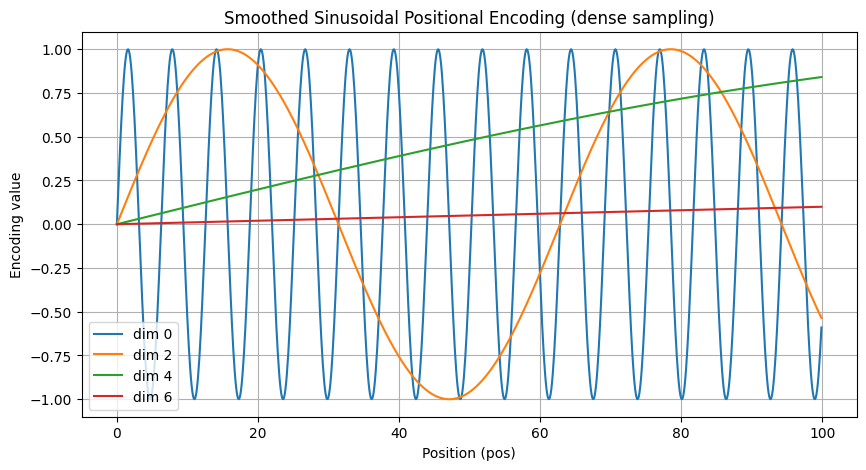

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 参数
d_model = 8
pos = torch.arange(0, 100, 0.1).unsqueeze(1).float()  # 更密集的采样点
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

pe = torch.zeros(pos.shape[0], d_model)
pe[:, 0::2] = torch.sin(pos * div_term)
pe[:, 1::2] = torch.cos(pos * div_term)

# 只画 4 个维度
plt.figure(figsize=(10, 5))
for i in [0, 2, 4, 6]:
    plt.plot(pos.squeeze().numpy(), pe[:, i].numpy(), label=f'dim {i}')
plt.title("Smoothed Sinusoidal Positional Encoding (dense sampling)")
plt.xlabel("Position (pos)")
plt.ylabel("Encoding value")
plt.legend()
plt.grid(True)
plt.show()


dim 0：波动非常快（高频）

dim 2、4：波动逐渐变慢（中频）

dim 6：波长最长（低频）

不同维度 i 对应的正弦波频率不同——从局部快速变化到全局缓慢变化，从而让模型同时捕捉短程顺序和长程依赖。


| 类型                   | 示例                                | 说明                      |
| -------------------- | --------------------------------- | ----------------------- |
| **Parameter（可训练参数）** | `self.weight = nn.Parameter(...)` | 参与梯度更新，优化器会自动更新         |
| **Buffer（缓冲状态）**     | `self.register_buffer("pe", pe)`  | 不参与训练，但需要跟随模型保存/加载/迁移设备 |

我们计算好一整个位置编码矩阵 不需要训练梯度（固定正弦函数，不学习）
能随模型一起保存 / 加载（例如 checkpoint）
能自动迁移到 GPU / CPU


Tokenize :将文本拆分成更小的单元（token），如单词、子词或字符，便于模型处理和理解语言结构。

Embedding :将离散的 token 映射到连续的向量空间中，捕捉词语之间的语义关系和上下文信息。

Positional Encoding :为序列中的每个 token 添加位置信息，使模型能够理解词语在序列中的顺序和相对位置关系。

Encoder :由多个注意力层和前馈神经网络层组成，负责处理输入序列，提取特征并生成上下文相关的表示。